## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:

from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model


"""
建立神經網路，並加入 BN layer
"""
def build_mlp_before_activation(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = BatchNormalization()(input_layer)
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
        else:
            x = BatchNormalization()(x)
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model


def build_mlp_after_input(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = BatchNormalization()(input_layer)
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZES = [256, 128,64]
MOMENTUM = 0.95

In [7]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for BATCH_SIZE in BATCH_SIZES:
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    exp_name_tag = "BATCH_SIZE %s" %(BATCH_SIZE)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512 

50000/50000 [==============================] - 9s 188us/step - loss: 0.2083 - accuracy: 0.9410 - val_loss: 2.3512 - val_accuracy: 0.4780
Epoch 47/50
50000/50000 [==============================] - 10s 194us/step - loss: 0.1939 - accuracy: 0.9456 - val_loss: 2.2813 - val_accuracy: 0.4750
Epoch 48/50
50000/50000 [==============================] - 9s 187us/step - loss: 0.1768 - accuracy: 0.9523 - val_loss: 2.3878 - val_accuracy: 0.4732
Epoch 49/50
50000/50000 [==============================] - 9s 187us/step - loss: 0.1729 - accuracy: 0.9534 - val_loss: 2.4601 - val_accuracy: 0.4785
Epoch 50/50
50000/50000 [==============================] - 9s 184us/step - loss: 0.1637 - accuracy: 0.9556 - val_loss: 2.4197 - val_accuracy: 0.4747
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
___________________________________________________

50000/50000 [==============================] - 15s 297us/step - loss: 0.3710 - accuracy: 0.8703 - val_loss: 2.2067 - val_accuracy: 0.4659
Epoch 42/50
50000/50000 [==============================] - 16s 310us/step - loss: 0.3451 - accuracy: 0.8817 - val_loss: 2.3360 - val_accuracy: 0.4547
Epoch 43/50
50000/50000 [==============================] - 15s 297us/step - loss: 0.3337 - accuracy: 0.8857 - val_loss: 2.3410 - val_accuracy: 0.4514
Epoch 44/50
50000/50000 [==============================] - 15s 305us/step - loss: 0.3242 - accuracy: 0.8889 - val_loss: 2.2032 - val_accuracy: 0.4726
Epoch 45/50
50000/50000 [==============================] - 14s 290us/step - loss: 0.3036 - accuracy: 0.8977 - val_loss: 2.3363 - val_accuracy: 0.4577
Epoch 46/50
50000/50000 [==============================] - 15s 300us/step - loss: 0.2992 - accuracy: 0.8977 - val_loss: 2.3550 - val_accuracy: 0.4695
Epoch 47/50
50000/50000 [==============================] - 14s 290us/step - loss: 0.2847 - accuracy: 0.9025 - va

Epoch 36/50
50000/50000 [==============================] - 24s 487us/step - loss: 0.6563 - accuracy: 0.7650 - val_loss: 1.6987 - val_accuracy: 0.5001
Epoch 37/50
50000/50000 [==============================] - 27s 534us/step - loss: 0.6558 - accuracy: 0.7664 - val_loss: 1.8589 - val_accuracy: 0.4826
Epoch 38/50
50000/50000 [==============================] - 25s 508us/step - loss: 0.6580 - accuracy: 0.7645 - val_loss: 1.7954 - val_accuracy: 0.4761
Epoch 39/50
50000/50000 [==============================] - 25s 501us/step - loss: 0.6351 - accuracy: 0.7709 - val_loss: 1.7412 - val_accuracy: 0.4965
Epoch 40/50
50000/50000 [==============================] - 24s 489us/step - loss: 0.6086 - accuracy: 0.7814 - val_loss: 1.8060 - val_accuracy: 0.4925
Epoch 41/50
50000/50000 [==============================] - 24s 478us/step - loss: 0.6009 - accuracy: 0.7849 - val_loss: 1.8319 - val_accuracy: 0.4912
Epoch 42/50
50000/50000 [==============================] - 23s 457us/step - loss: 0.5875 - accuracy:

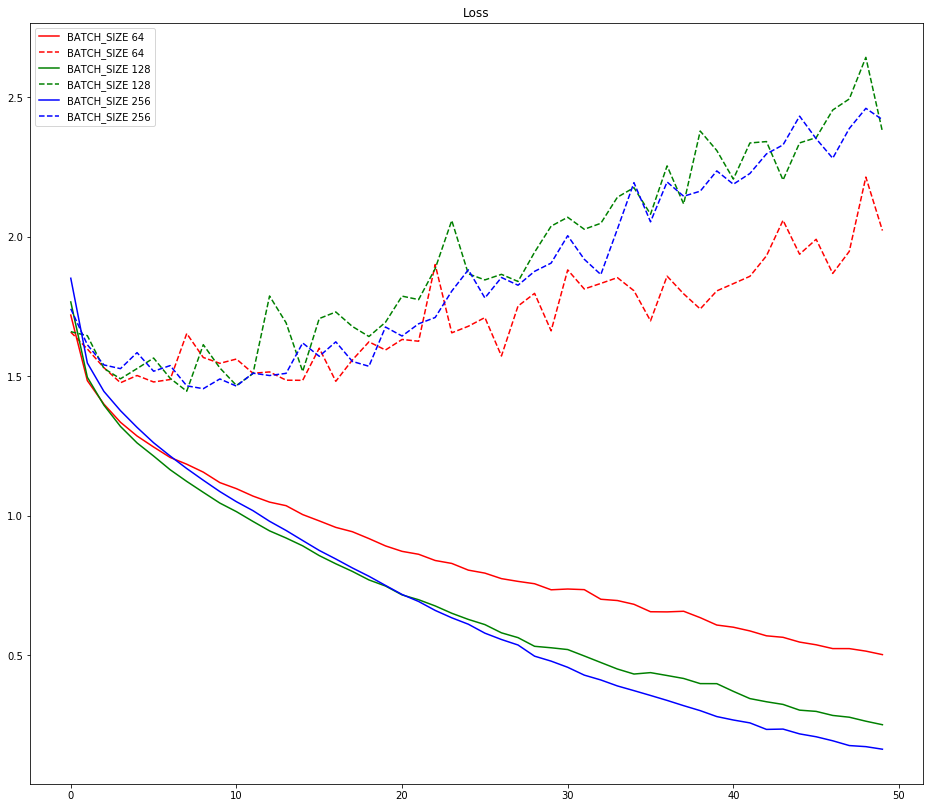

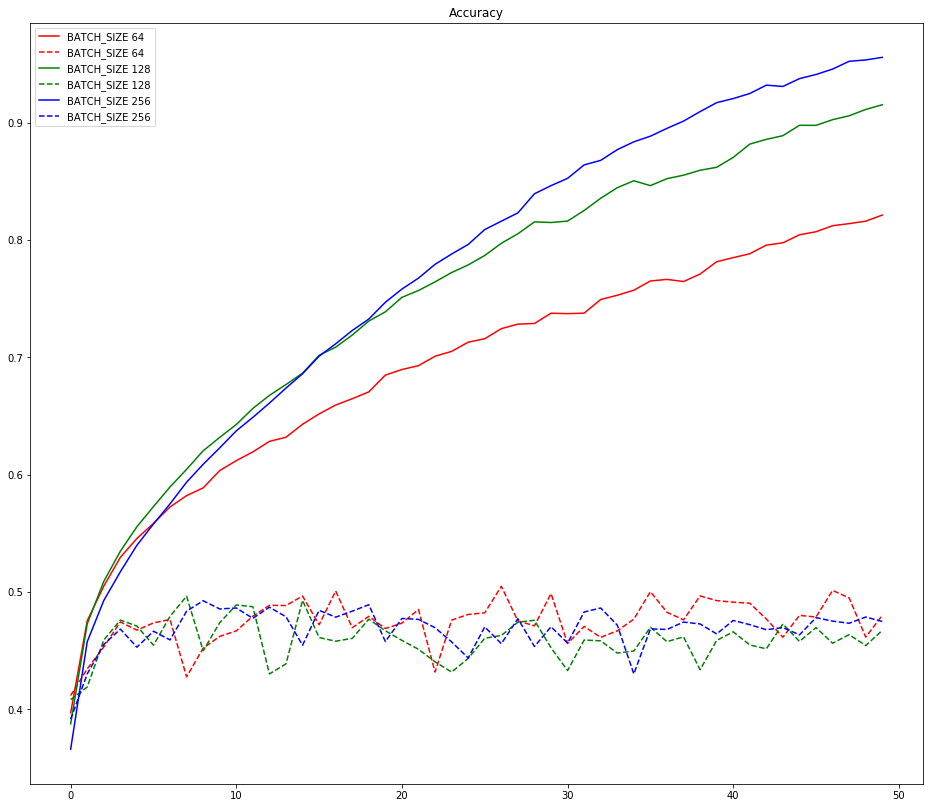

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k",'c','coral']

plt.figure(figsize=(16,14))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(16,14))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()